In [109]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



In [110]:
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_df[1] = self.label_encoder.fit_transform(self.labels_df[1])

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.tensor(self.labels_df.iloc[idx, 1], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Create custom dataset
dataset = CustomDataset(csv_file='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/labels.txt', root_dir='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/images', transform=transform)

# Load the trained model for prediction
model = torchvision.models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))
model.load_state_dict(torch.load( '/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/models/torch.pth'))
model.eval()


# Define function to predict category of a query image
def predict_category(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_label = dataset.label_encoder.inverse_transform([predicted.item()])  # Convert to list
    return predicted_label[0]

def extract_colors(image_path, num_colors=5):
    image = cv2.imread(image_path)
    
    # Convert image from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Flatten the image to a 2D array of pixels
    pixels = image.reshape(-1, 3)
    
    # Apply K-means clustering to find dominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    
    # Get the dominant colors
    colors = kmeans.cluster_centers_
    
    return colors.astype(int)

def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

def display_colors(colors):
    # Create a square image with the extracted colors
    color_img = np.zeros((100, len(colors)*100, 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        color_img[:, i*100:(i+1)*100] = color
        # Convert RGB to hex and print
        hex_color = rgb_to_hex(color)
        print(f"Color {i+1}: {hex_color}")
     
    print("\n")
    # Display the image using matplotlib
    plt.imshow(color_img)
    plt.axis('off')
    plt.show()



Predicted category for query image: Apparel


Color 1: #0201c3
Color 2: #fefefd
Color 3: #04037f
Color 4: #898bc8
Color 5: #0201a7




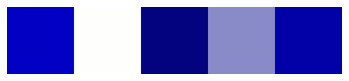

In [119]:
# Example
query_image_path = "/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/blue.jpeg"  # Full path to the image file
predicted_category = predict_category(query_image_path)  # Call predict_category with the correct image path
colors = extract_colors(query_image_path)
print(f"Predicted category for query image: {predicted_category}")
print("\n")
display_colors(colors)


## Colour Classification

In [120]:
rgb_shades_df = pd.read_csv('/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/colours_rgb_shades_clean.csv')

In [121]:
def find_closest_hex_color(extracted_hex_colors, color_df):
    closest_colors = []
    for hex_color in extracted_hex_colors:
        hex_color = hex_color.lstrip('#')  # Ensure we're working with the HEX part only

        # Calculate the distance to each color in the dataframe
        distances = color_df['RGB Hex'].apply(
            lambda x: sum((int(x[i:i+2], 16) - int(hex_color[i:i+2], 16)) ** 2 for i in (0, 2, 4))
            if len(x) == 6 else float('inf')
        )

        # Get the index of the closest color
        closest_index = distances.idxmin()
        closest_color = color_df.iloc[closest_index]
        closest_colors.append((closest_color['Color Name'], closest_color['RGB Hex']))

    return closest_colors


Closest color names and HEX values:
New Midnight Blue: #00009C
grey100, White: #FFFFFF
Dark Turquoise: #7093DB
blue4: #00008B
MediumBlue: #0000CD


Color 1: #0201a7
Color 2: #fefefd
Color 3: #898bc8
Color 4: #04037f
Color 5: #0201c3




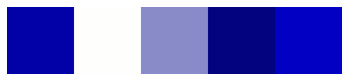

In [122]:
# Example usage
#query_image_path = "/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/glass.png"  # Full path to the image file
predicted_category = predict_category(query_image_path)  
colors = extract_colors(query_image_path)

# Convert extracted colors to HEX format
extracted_hex_colors = [rgb_to_hex(color) for color in colors]

# Find and display the closest colors along with their names
closest_colors_info = find_closest_hex_color(extracted_hex_colors, rgb_shades_df)
print("Closest color names and HEX values:")
for color_name, hex_color in closest_colors_info:
    print(f"{color_name}: #{hex_color}")

print("\n")
# Optionally, display the extracted colors
display_colors(colors)
